Задание 1: Атака на модель машинного обучения

Была выбрана нейросеть на Keras, обученная на датасете MNIST (изображения рукописных цифр 28×28 пикселей)

Aтака Fast Gradient Sign Method (FGSM)

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 1s 21us/sample - loss: 0.3709 - accuracy: 0.8983 - val_loss: 0.1640 - val_accuracy: 0.9550
Epoch 2/3
 6016/54000 [==>...........................] - ETA: 0s - loss: 0.1828 - accuracy: 0.9488

/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


54000/54000 [==============================] - 1s 19us/sample - loss: 0.1703 - accuracy: 0.9519 - val_loss: 0.1178 - val_accuracy: 0.9680
Epoch 3/3
54000/54000 [==============================] - 1s 20us/sample - loss: 0.1237 - accuracy: 0.9650 - val_loss: 0.0972 - val_accuracy: 0.9723


/usr/local/lib/python3.11/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Точность на обычных данных: 96.63%
Точность на атакованных данных: 2.12%


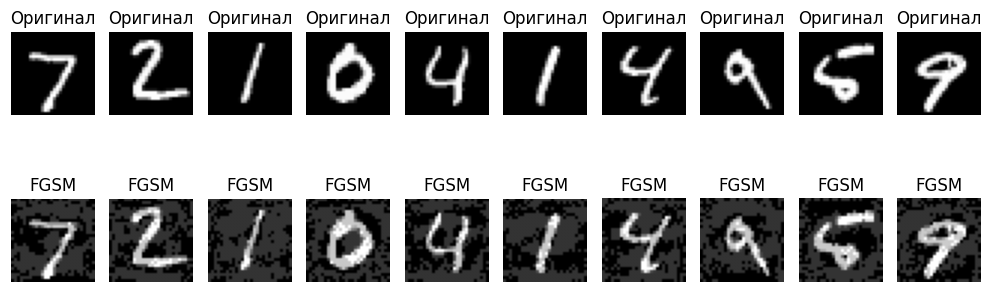

Train on 108000 samples, validate on 12000 samples
Epoch 1/3
108000/108000 [==============================] - 2s 21us/sample - loss: 0.2910 - accuracy: 0.9272 - val_loss: 0.1417 - val_accuracy: 0.9695
Epoch 2/3
108000/108000 [==============================] - 3s 26us/sample - loss: 0.1339 - accuracy: 0.9652 - val_loss: 0.1113 - val_accuracy: 0.9707
Epoch 3/3
108000/108000 [==============================] - 2s 20us/sample - loss: 0.0934 - accuracy: 0.9735 - val_loss: 0.0947 - val_accuracy: 0.9726

[Защита] Точность на обычных данных: 97.29%
[Защита] Точность на атакованных данных: 96.82%


In [ ]:
!pip install -U numpy==1.23.5 scikit-learn==1.1.3 tensorflow==2.12.0 adversarial-robustness-toolbox==1.14.0

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier

# Загрузка и подготовка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Нормализация значений в диапазон [0, 1]
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Добавление канала (28x28x1), т.к. модель ожидает 4D вход
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Кодирование меток
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

### Задание 1. Атака Fast Gradient Sign Method (FGSM)

# Простая модель нейросети
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(x_train, y_train_cat, epochs=3, batch_size=128, validation_split=0.1)

# Обёртка ART для модели
classifier = KerasClassifier(model=model, clip_values=(0, 1))

# FGSM атака
attack = FastGradientMethod(estimator=classifier, eps=0.2)

# Генерация атакованных изображений на основе тестового набора
x_test_adv = attack.generate(x=x_test)

# Оценка точности модели до и после атаки
_, acc_clean = model.evaluate(x_test, y_test_cat, verbose=0) # _ по сути не нужная сейчас переменная loss — значение функции потерь на тестовых данных
_, acc_adv = model.evaluate(x_test_adv, y_test_cat, verbose=0)

print(f"\nТочность на обычных данных: {acc_clean * 100:.2f}%")
print(f"Точность на атакованных данных: {acc_adv * 100:.2f}%")

# Визуализация 10 примеров до и после атаки
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Оригинал")
    plt.axis('off')

    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_adv[i].reshape(28, 28), cmap='gray')
    plt.title("FGSM")
    plt.axis('off')
plt.tight_layout()
plt.show()

    ### Задание 2. Защита: Обучение на атакованных данных (Adversarial Training) ###

# Объединение оригинальных и атакованных данных
x_combined = np.concatenate((x_train, attack.generate(x=x_train)))
y_combined = np.concatenate((y_train_cat, y_train_cat))  # метки не меняются

# Обучение новой модели на расширенном наборе данных
model_defended = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model_defended.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Обучение модели на атакованных и нормальных примерах
model_defended.fit(x_combined, y_combined, epochs=3, batch_size=128, validation_split=0.1)

# Повторная обёртка
classifier_defended = KerasClassifier(model=model_defended, clip_values=(0, 1))

# Оценка точности защищённой модели
_, acc_clean_def = model_defended.evaluate(x_test, y_test_cat, verbose=0)
_, acc_adv_def = model_defended.evaluate(x_test_adv, y_test_cat, verbose=0)

print(f"\n[Защита] Точность на обычных данных: {acc_clean_def * 100:.2f}%")
print(f"[Защита] Точность на атакованных данных: {acc_adv_def * 100:.2f}%")
